In [1]:
from models import preflop_model

model = preflop_model()
model.summary()

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                544       
_________________________________________________________________
dense_2 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_3 (Dense)              (None, 16)                1040      
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 34        
Total params: 3,730
Trainable params: 3,730
Non-trainable params: 0
_________________________________________________________________


In [2]:
from engine import Engine
from treys import Card
import numpy as np
from constants import Actions

engine = Engine()


In [10]:
num_hands = 100000
total_reward = 0

e = 0.1
loss = []

sb_pushed_plt = []
bb_called_plt = []

state_sb = np.zeros((16))
state_bb = np.zeros((16))

targetQ = np.zeros((2))

bankroll_sb = [0]
player1 = True

replay_state = []
replay_Q = []
max_replay = 10000

sb_pushed = 0
bb_called = 0


for i in range(num_hands):
    reward_sb = 0
    reward_bb = 0

  
    engine.new_hand(starting_stack=np.random.randint(40,400))

    sb_features = np.concatenate([engine.get_pocket_cards_features(0),np.array([engine.has_suited_pockets(0),1,engine.starting_stack/400])]).reshape((1,16))
    bb_features = np.concatenate([engine.get_pocket_cards_features(1),np.array([engine.has_suited_pockets(1),0,engine.starting_stack/400])]).reshape((1,16))

    replay_state.append(sb_features.reshape((16,)))
    
    
    #run model to choose action
    allQ_sb = model.predict(sb_features)
    action_sb = np.argmax(allQ_sb)
    allQ_bb = model.predict(bb_features)
    action_bb = np.argmax(allQ_bb)

    #randomly discover new line
    if(np.random.rand(1) < e):

        action_sb = np.random.randint(0,2)
        action_bb = np.random.randint(0,2)
        

    if action_sb == 1:
        sb_pushed +=1
        engine.play_action(Actions.BET,engine.get_bet_range()[1])
    
        
        if action_bb == 1:
            bb_called +=1
            engine.play_action(Actions.CALL, 0)  
        else:
            engine.play_action(Actions.FOLD,0)

    else:
        engine.play_action(Actions.FOLD,0)
    

    if engine.winner != -1:
        r = engine.get_sb_won()

    else:
        print('not fichished walla')
    total_reward +=r
    bankroll_sb.append(bankroll_sb[-1]+r)
    
    allQ_sb[0,action_sb] = r
    replay_Q.append(allQ_sb.reshape((2,)))
    
    #train only if sb played. otherwise positive reward for folding
    if action_sb == 1:
        replay_state.append(bb_features.reshape((16,)))
        allQ_bb[0,action_bb] = -r
        replay_Q.append(allQ_bb.reshape((2,)))
    
    if(i%500 == 0 and i > 0):
        print(i)

    if(i%5000== 0 and i > 0):
        sb_pushed_pct = int(sb_pushed/(i+1)*100)
        sb_pushed_plt.append(sb_pushed_pct)
        bb_called_pct = int(bb_called/(sb_pushed+1)*100)
        bb_called_plt.append(bb_called_pct)
        print('\n\nround',i)
        print('Won(SB):',r,'  Total won (SB):',total_reward)
        print('SB pushed ' + str(sb_pushed_pct)+'% , BB called '+  str(bb_called_pct)+'%' )
        print('sb_features')
        print(sb_features)
        print('allQ_sb:')
        print(allQ_sb)
        print('\nbb_features')
        print(bb_features)
        print('allQ_bb:')   
        print(allQ_bb)
        
                
        model.fit(np.stack(replay_state),np.stack(replay_Q),verbose=1,epochs=5)


    if(len(replay_state) > max_replay):
        replay_state = replay_state[50:]
        replay_Q = replay_Q[50:]


500
1000
1500
2000
2500
3000
3500
4000
4500
5000


round 5000
Won(SB): 20   Total won (SB): -1614
SB pushed 54% , BB called 43%
sb_features
[[0.   0.   1.   0.   0.   0.   0.   0.   0.   0.   0.   1.   0.   0.
  1.   0.68]]
allQ_sb:
[[-7.9164133 20.       ]]

bb_features
[[0.   0.   0.   0.   0.   0.   1.   0.   0.   0.   0.   1.   0.   0.
  0.   0.68]]
allQ_bb:
[[-20.      -31.53208]]
Epoch 1/5
7734/7734 [==============================] - 0s 19us/step - loss: 4881.2466
Epoch 2/5
7734/7734 [==============================] - 0s 19us/step - loss: 4857.7990
Epoch 3/5
7734/7734 [==============================] - 0s 19us/step - loss: 4833.2827
Epoch 4/5
7734/7734 [==============================] - 0s 18us/step - loss: 4829.5397
Epoch 5/5
7734/7734 [==============================] - 0s 19us/step - loss: 4817.1202
5500
6000
6500
7000
7500
8000
8500
9000
9500
10000


round 10000
Won(SB): -10   Total won (SB): -6630
SB pushed 55% , BB called 43%
sb_features
[[0.   1.   0.   0.   1.   0.   0.   

9990/9990 [==============================] - 0s 19us/step - loss: 5826.5834
Epoch 4/5
9990/9990 [==============================] - 0s 19us/step - loss: 5816.1699
Epoch 5/5
9990/9990 [==============================] - 0s 18us/step - loss: 5806.0049
50500
51000
51500
52000
52500
53000
53500
54000
54500
55000


round 55000
Won(SB): -10   Total won (SB): -37483
SB pushed 58% , BB called 46%
sb_features
[[1.     1.     0.     0.     0.     0.     0.     0.     0.     0.
  0.     0.     0.     1.     1.     0.3525]]
allQ_sb:
[[-10.     -27.3728]]

bb_features
[[0.     0.     0.     0.     0.     0.     1.     0.     0.     0.
  1.     0.     0.     0.     0.     0.3525]]
allQ_bb:
[[-16.607244 -19.758196]]
Epoch 1/5
9975/9975 [==============================] - 0s 18us/step - loss: 4820.1852
Epoch 2/5
9975/9975 [==============================] - 0s 19us/step - loss: 4770.2359
Epoch 3/5
9975/9975 [==============================] - 0s 18us/step - loss: 4748.0752
Epoch 4/5
9975/9975 [============

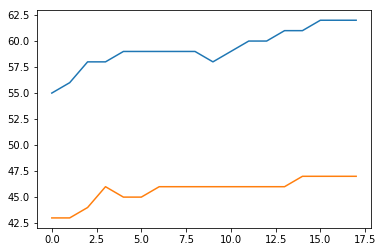

In [ ]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

plt.plot(sb_pushed_plt[1:])
plt.plot(bb_called_plt[1:])

In [ ]:
from metrics import compute_nash_pusher
from metrics import compute_nash_caller
call_nash = compute_nash_caller(model)
push_chart = compute_nash_pusher(model)

In [ ]:
sns.heatmap(push_chart)

In [ ]:
sns.heatmap(call_nash)

In [ ]:
call_nash


In [ ]:
from models import save_model

save_model(model,'pushfold4')

In [ ]:
from models import load

model = load('pushfold')